# Tuning a combined query

This looks at tuning a more complex, combined query which is composed of specialised sub-queries.

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import importlib
import os
import sys

from copy import deepcopy
from elasticsearch import Elasticsearch
from skopt.plots import plot_objective

In [10]:
# project library
sys.path.insert(0, os.path.abspath('..'))

import qopt
importlib.reload(qopt)

from qopt.notebooks import evaluate_mrr100_dev, evaluate_mrr100_dev_templated, optimize_query_mrr100, optimize_query_mrr100_templated
from qopt.optimize import Config

In [11]:
# use a local Elasticsearch or Cloud instance (https://cloud.elastic.co/)
# es = Elasticsearch('http://localhost:9200')
es = Elasticsearch('http://35.246.228.72:9200')

# set the parallelization parameter `max_concurrent_searches` for the Rank Evaluation API calls
# max_concurrent_searches = 10
max_concurrent_searches = 30

index = 'msmarco-document.doc2query'
template_id = 'combined-doc2query-cross_fields'

# base template for tuning
base_templates = [{
    "id": 'query',
    "template": {
        "lang": "mustache",
        "source": { "query": {} }
    }
}]

## Baseline evaluation

In [10]:
%%time

_ = evaluate_mrr100_dev(es, max_concurrent_searches, index, template_id,
    params={
        'bigram_fields|minimum_should_match': 50,
        'bigram_fields|tie_breaker': 0.0,
        'bigram_fields|body|boost': 1.0,
        'bigram_fields|expansions|boost': 1.0,
        'bigram_fields|boost': 1.0,
        'base_fields|minimum_should_match': 50,
        'base_fields|tie_breaker': 0.0,
        'base_fields|url|boost': 1.0,
        'base_fields|title|boost': 1.0,
        'base_fields|body|boost': 1.0,
        'base_fields|expansions|boost': 1.0,
        'base_fields|boost': 1.0,
    })

Evaluation with: MRR@100
Score: 0.3205
CPU times: user 2.61 s, sys: 700 ms, total: 3.31 s
Wall time: 7min 47s


## Optimization

In [53]:
%%time

_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": "best_fields",
    "query": "{{query_string}}",
    "tie_breaker": "{{tie_breaker}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "body^{{body|boost}}",
        "body.bigrams^{{body_bigrams|boost}}",
        "expansions^{{expansions|boost}}",
        "expansions.bigrams^{{expansions_bigrams|boost}}"
    ]
}

_, _, final_params_a, metadata_a = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, 'query',
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'tie_breaker': { 'low': 0.0, 'high': 1.0 },
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'body_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        },
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:01:37 (remains: 1:19:13)
   | 0.2967 (best: 0.2967) - {'tie_breaker': 0.2205226608606387, 'url|boost': 2.952211569783127, 'title|boost': 7.14257585185269, 'body|boost': 1.3098723142005988, 'body_bigrams|boost': 2.7012589015872828, 'expansions|boost': 3.977449468214167, 'expansions_bigrams|boost': 4.463620355824981}
 > iteration 2/50, took 0:01:35 (remains: 1:16:38)
   | 0.2790 (best: 0.2967) - {'tie_breaker': 0.9875437126786867, 'url|boost': 4.765477053190759, 'title|boost': 0.998681393174853, 'body|boost': 2.4659120207955714, 'body_bigrams|boost': 6.973067965529172, 'expansions|boost': 1.0975621461231435, 'expansions_bigrams|boost': 7.558351542355134}
 > iteration 3/50, took 0:01:43 (remains: 1:21:00)
   | 0.2857 (best: 0.2967) - {'tie_breaker': 0.8853274031022038, 'url|boost': 7.666594291694162, 'tit

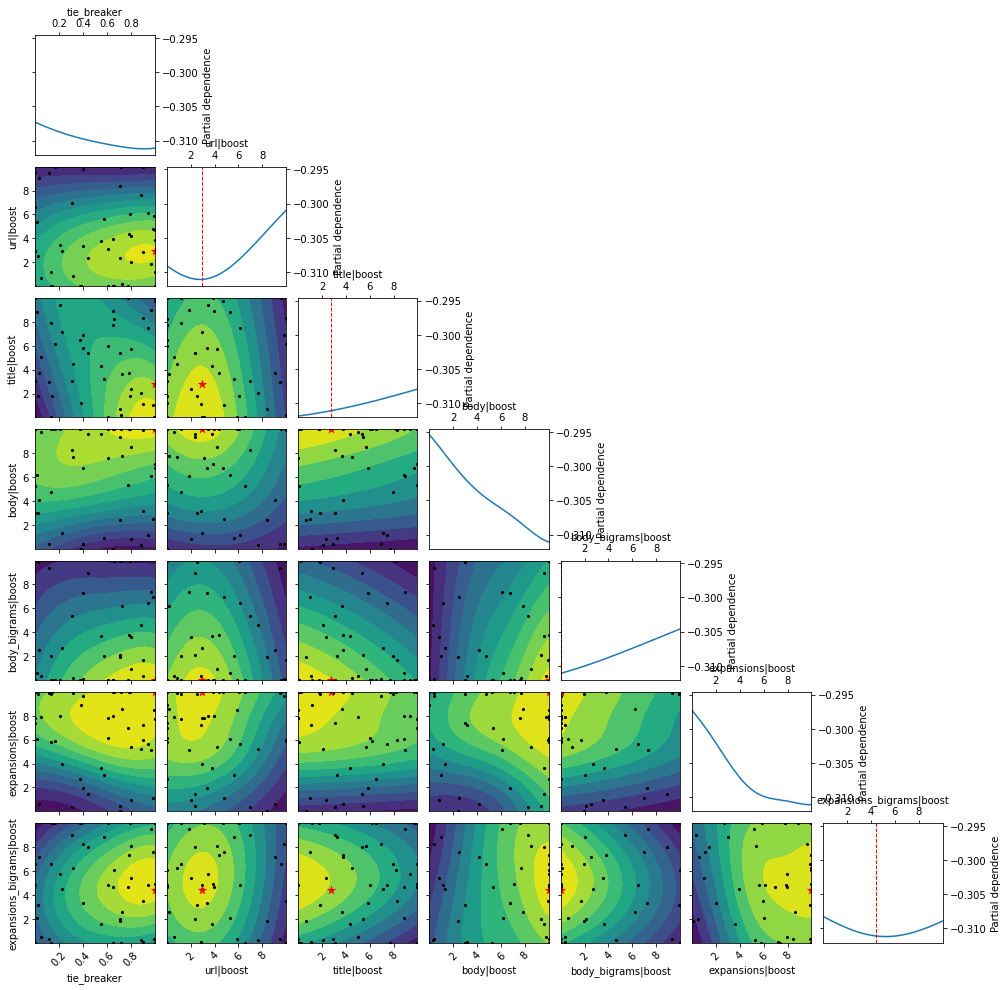

In [54]:
_ = plot_objective(metadata_a, sample_source='result')

In [55]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, 'query', params=final_params_a)

Evaluation with: MRR@100
Score: 0.3376
CPU times: user 2.81 s, sys: 1.42 s, total: 4.22 s
Wall time: 8min 31s


## Experiments

In [15]:
#  - iteration 58 scored 0.3172
# 0.3394
# current best approach

#             "should": [
#               {
#                 "multi_match": {
#                   "type": "cross_fields",
#                   "query": "{{query_string}}",
#                   "minimum_should_match": "{{bigram_fields|minimum_should_match}}%",
#                   "tie_breaker": "{{bigram_fields|tie_breaker}}",
#                   "fields": [
#                     "body.bigrams^{{bigram_fields|body|boost}}",
#                     "expansions.bigrams^{{bigram_fields|expansions|boost}}"
#                   ],
#                   "boost": "{{bigram_fields|boost}}"
#                 }
#               },
#               {
#                 "multi_match": {
#                   "type": "cross_fields",
#                   "query": "{{query_string}}",
#                   "minimum_should_match": "{{base_fields|minimum_should_match}}%",
#                   "tie_breaker": "{{base_fields|tie_breaker}}",
#                   "fields": [
#                     "url^{{base_fields|url|boost}}",
#                     "title^{{base_fields|title|boost}}",
#                     "body^{{base_fields|body|boost}}",
#                     "expansions^{{base_fields|expansions|boost}}"
#                   ],
#                   "boost": "{{base_fields|boost}}"
#                 }
#               }
#             ]

{
    'bigram_fields|minimum_should_match': 10,
    'bigram_fields|tie_breaker': 0.7848747833900612,
    'bigram_fields|body|boost': 0.0,
    'bigram_fields|expansions|boost': 2.6845888973896614,
    'bigram_fields|boost': 5.351866743180889,
    'base_fields|minimum_should_match': 10,
    'base_fields|tie_breaker': 0.23112148889030892,
    'base_fields|url|boost': 4.909321762819287,
    'base_fields|title|boost': 6.89954855874351,
    'base_fields|body|boost': 10.0,
    'base_fields|expansions|boost': 6.2476492335350144,
    'base_fields|boost': 6.497903117142636
}

{'bigram_fields|minimum_should_match': 10,
 'bigram_fields|tie_breaker': 0.7848747833900612,
 'bigram_fields|body|boost': 0.0,
 'bigram_fields|expansions|boost': 2.6845888973896614,
 'bigram_fields|boost': 5.351866743180889,
 'base_fields|minimum_should_match': 10,
 'base_fields|tie_breaker': 0.23112148889030892,
 'base_fields|url|boost': 4.909321762819287,
 'base_fields|title|boost': 6.89954855874351,
 'base_fields|body|boost': 10.0,
 'base_fields|expansions|boost': 6.2476492335350144,
 'base_fields|boost': 6.497903117142636}

In [13]:
# 0.3339

_templates[0]['template']['source']['query']['multi_match'] = {
    "type": "most_fields",
    "query": "{{query_string}}",
    "fields": [
        "body^{{body|boost}}",
        "body.bigrams^{{body_bigrams|boost}}",
        "expansions^{{expansions|boost}}",
        "expansions.bigrams^{{expansions_bigrams|boost}}"
    ]
}

{
    'body|boost': 10.0,
    'body_bigrams|boost': 0.0,
    'expansions|boost': 10.0,
    'expansions_bigrams|boost': 2.187828564745356
}

{'body|boost': 10.0,
 'body_bigrams|boost': 0.0,
 'expansions|boost': 10.0,
 'expansions_bigrams|boost': 2.187828564745356}

In [12]:
# 0.3369
# current second best simple approach

_templates[0]['template']['source']['query']['multi_match'] = {
    "type": "most_fields",
    "query": "{{query_string}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "body^{{body|boost}}",
        "body.bigrams^{{body_bigrams|boost}}",
        "expansions^{{expansions|boost}}",
        "expansions.bigrams^{{expansions_bigrams|boost}}"
    ]
}

{
    'url|boost': 10.0,  # 10.0
    'title|boost': 9.098236987200911,  # 10.0
    'body|boost': 69.36954104578494,  # 100.0
    'body_bigrams|boost': 10.0,  # 10.0
    'expansions|boost': 82.29832181000859,  # 100.0
    'expansions_bigrams|boost': 10.0 # 10.0
}

{'url|boost': 10.0,
 'title|boost': 9.098236987200911,
 'body|boost': 69.36954104578494,
 'body_bigrams|boost': 10.0,
 'expansions|boost': 82.29832181000859,
 'expansions_bigrams|boost': 10.0}

In [ ]:
# same as above but with ranges 0-100 for all
# 0.3338

{
    'url|boost': 29.407745913673295,
    'title|boost': 10.770599300552256,
    'body|boost': 89.14231867176755,
    'body_bigrams|boost': 20.09339790083145,
    'expansions|boost': 50.144906120423926,
    'expansions_bigrams|boost': 44.41958107048871
}

In [ ]:
# 0.3357

_templates[0]['template']['source']['query']['multi_match'] = {
    "type": "best_fields",
    "query": "{{query_string}}",
    "tie_breaker": "{{tie_breaker}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "body^{{body|boost}}",
        "body.bigrams^{{body_bigrams|boost}}",
        "expansions^{{expansions|boost}}",
        "expansions.bigrams^{{expansions_bigrams|boost}}"
    ]
}

{
    'tie_breaker': 1.0,
    'url|boost': 8.955498568160035,
    'title|boost': 5.496629274847367,
    'body|boost': 87.48784558517542,
    'body_bigrams|boost': 9.587535217446536,
    'expansions|boost': 100.0,
    'expansions_bigrams|boost': 8.395113849121143
}

In [ ]:
# same as above but without bigrams
# 0.3310

{
    'tie_breaker': 0.49669723678780886,
    'url|boost': 8.277133721280101,
    'title|boost': 4.053752992902719,
    'body|boost': 82.15183564170239,
    'expansions|boost': 61.81339425751388
}

In [ ]:
# lots of iterations with best_fields, ranges all 0-10
# 0.3376

{
    'tie_breaker': 1.0,
    'url|boost': 2.9419535991257746,
    'title|boost': 2.760451754400211,
    'body|boost': 10.0,
    'body_bigrams|boost': 0.0, 
    'expansions|boost': 10.0,
    'expansions_bigrams|boost': 4.376102370736655
}

In [ ]:
# lots of iterations with most_fields, ranges all 0-10
# 0.3379
# current best simple approach

_templates[0]['template']['source']['query']['multi_match'] = {
    "type": "most_fields",
    "query": "{{query_string}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "body^{{body|boost}}",
        "body.bigrams^{{body_bigrams|boost}}",
        "expansions^{{expansions|boost}}",
        "expansions.bigrams^{{expansions_bigrams|boost}}"
    ]
}

{
    'method': 'bayesian',
    'num_iterations': 50,
    'num_initial_points': 20,
    'space': {
        'url|boost': { 'low': 0.0, 'high': 10.0 },
        'title|boost': { 'low': 0.0, 'high': 10.0 },
        'body|boost': { 'low': 0.0, 'high': 10.0 },
        'body_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        'expansions|boost': { 'low': 0.0, 'high': 10.0 },
        'expansions_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
    },
}

{
    'url|boost': 1.9800253060472908,
    'title|boost': 0.0,
    'body|boost': 10.0,
    'body_bigrams|boost': 0.0,
    'expansions|boost': 10.0,
    'expansions_bigrams|boost': 2.0842057354042214
}

In [ ]:
# same as above but without body.bigrams
# 0.3360

{
    'url|boost': 4.230904251341346,
    'title|boost': 0.0,
    'body|boost': 10.0,
    'expansions|boost': 7.979068020699827,
    'expansions_bigrams|boost': 4.744471195459435
}

In [ ]:
# complex query 1
#  0.3349

_templates[0]['template']['source']['query']['bool'] = { "should": [
    {
        "multi_match": {
            "type": "most_fields",
            "query": "{{query_string}}",
            "fields": [
                "body^{{long_fields|body|boost}}",
                "body.bigrams^{{long_fields|body_bigrams|boost}}",
                "expansions^{{long_fields|expansions|boost}}",
                "expansions.bigrams^{{long_fields|expansions_bigrams|boost}}"
            ]
            "boost": "{{long_fields|boost}}"
        }
    },
    {
        "multi_match": {
            "type": "best_fields",
            "query": "{{query_string}}",
            "fields": [
                "url^{{short_fields|url|boost}}",
                "title^{{short_fields|title|boost}}",
            ],
            "boost": "{{short_fields|boost}}"
        }
    }
]}

{
    'method': 'bayesian',
    'num_iterations': 50,
    'num_initial_points': 20,
    'space': {
        'long_fields|body|boost': { 'low': 0.0, 'high': 10.0 },
        'long_fields|body_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        'long_fields|expansions|boost': { 'low': 0.0, 'high': 10.0 },
        'long_fields|expansions_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        'long_fields|boost': { 'low': 0.0, 'high': 10.0 },            
        'short_fields|url|boost': { 'low': 0.0, 'high': 10.0 },
        'short_fields|title|boost': { 'low': 0.0, 'high': 10.0 },
        'short_fields|boost': { 'low': 0.0, 'high': 10.0 },
    },
}

{
    'long_fields|body|boost': 4.576599043562212,
    'long_fields|body_bigrams|boost': 0.0,
    'long_fields|expansions|boost': 10.0,
    'long_fields|expansions_bigrams|boost': 2.8456467224608866,
    'long_fields|boost': 10.0,
    'short_fields|url|boost': 10.0,
    'short_fields|title|boost': 0.0,
    'short_fields|boost': 0.0
}

In [ ]:
# complex query 2
# 0.3382
# best complex query not using cross_fields

_templates[0]['template']['source']['query']['bool'] = { "should": [
    {
        "multi_match": {
            "type": "most_fields",
            "query": "{{query_string}}",
            "fields": [
                "body^{{body_fields|body|boost}}",
                "body.bigrams^{{body_fields|body_bigrams|boost}}",
            ],
            "boost": "{{body_fields|boost}}"
        }
    },
    {
        "multi_match": {
            "type": "most_fields",
            "query": "{{query_string}}",
            "fields": [
                "expansions^{{expansions_fields|expansions|boost}}",
                "expansions.bigrams^{{expansions_fields|expansions_bigrams|boost}}"
            ],
            "boost": "{{expansions_fields|boost}}"
        }
    },
    {
        "multi_match": {
            "type": "best_fields",
            "query": "{{query_string}}",
            "fields": [
                "url^{{meta_fields|url|boost}}",
                "title^{{meta_fields|title|boost}}",
            ],
            "boost": "{{meta_fields|boost}}"
        }
    }
]}

{
    'method': 'bayesian',
    'num_iterations': 50,
    'num_initial_points': 20,
    'space': {
        'body_fields|body|boost': { 'low': 0.0, 'high': 10.0 },
        'body_fields|body_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        'body_fields|boost': { 'low': 0.0, 'high': 10.0 },
        'expansions_fields|expansions|boost': { 'low': 0.0, 'high': 10.0 },
        'expansions_fields|expansions_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        'expansions_fields|boost': { 'low': 0.0, 'high': 10.0 },            
        'meta_fields|url|boost': { 'low': 0.0, 'high': 10.0 },
        'meta_fields|title|boost': { 'low': 0.0, 'high': 10.0 },
        'meta_fields|boost': { 'low': 0.0, 'high': 10.0 },
    },
}

{
    'body_fields|body|boost': 10.0,
    'body_fields|body_bigrams|boost': 0.0,
    'body_fields|boost': 1.3003420442641567,
    'expansions_fields|expansions|boost': 10.0,
    'expansions_fields|expansions_bigrams|boost': 1.6128040657092853,
    'expansions_fields|boost': 6.6254493163701635,
    'meta_fields|url|boost': 10.0,
    'meta_fields|title|boost': 10.0,
    'meta_fields|boost': 2.377229312363788
}